In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, njit, vectorize, prange
import matplotlib
import matplotlib.cm as cm
import imageio
import os
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

%matplotlib inline

In [2]:
@njit('int64[:,:,:](int64[:,:,:], bool_)', parallel=True)
def add_padding(mp, is_periodic):
    padding = np.zeros((mp.shape[0] + 2, mp.shape[1] + 2, mp.shape[2] + 2), dtype=np.int64)
    padding[1:-1, 1:-1, 1:-1] = mp
    
    if is_periodic:
        padding[1:-1, 1:-1, -1] = padding[1:-1, 1:-1, 1]
        padding[1:-1, 1:-1, 0] = padding[1:-1, 1:-1, -2]

        padding[1:-1, -1, 1:-1] = padding[1:-1, 1, 1:-1]
        padding[1:-1, 0, 1:-1] = padding[1:-1, -2, 1:-1]

        padding[-1, 1:-1, 1:-1] = padding[1, 1:-1, 1:-1]
        padding[0, 1:-1, 1:-1] = padding[-2, 1:-1, 1:-1]
    
    return padding

In [3]:
@njit
def sum_matrix(matr):
    return np.sum(np.ravel(matr))

In [4]:
@njit(parallel=True)
def count_neighbours(mp):
    result = np.zeros((mp.shape[0], mp.shape[1], mp.shape[2]), dtype=np.int64)
    padded = add_padding(mp, is_periodic=True)

    for i in prange(mp.shape[0]):
        for j in prange(mp.shape[1]):
            for k in prange(mp.shape[2]):
                result[i, j, k] = sum_matrix(padded[i:i + 3, j:j + 3, k:k + 3])

    return np.subtract(result, mp)

In [20]:
# Conditions from: https://wpmedia.wolfram.com/uploads/sites/13/2018/02/01-3-1.pdf
@njit(parallel=True)
def step(mp):
    neighbours = count_neighbours(mp)
    
#     a, b, c, d = 5, 7, 6, 6
    a, b, c, d = 4, 5, 5, 5

    new_map = (
        (mp == 0) & ((neighbours >= c) & (neighbours <= d)) | 
        (mp == 1) & ((neighbours >= a) & (neighbours <= b))
    )
    
    return new_map

In [21]:
class Game3D:
    def __init__(self,
                 data=None,
                map_size=3,
                positive_ratio=0.3,
                is_periodic=True,
                load_map=False,
                map_name='',
                max_steps=100):
        
        self.map_size = map_size
        self.positive_ratio = positive_ratio
        self.is_periodic = is_periodic
        self.max_steps = max_steps
        
        if load_map:
            self.map = data.astype(int)
        else:
            self.generate_init_map()
        
        self.agents_count = sum_matrix(self.map)
        self.steps_count = 0
        self.file_name = (
            './data/' +
            '3dLife' + map_name + 
            '_s' + str(self.map.shape[0])
        )
        self.show_map(save=True, hide_axis=False)
    
    def generate_init_map(self):
        self.map = np.random.choice(
            2, 
            [self.map_size] * 3, 
            p=[1 - self.positive_ratio, self.positive_ratio]
        )
    
    def show_map(self, padded=False, save=False, hide_axis=False):      
        mp = self.padded if padded else self.map
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')
        ax.voxels(mp, facecolors=(0.2, 1.0, 0.2, 0.2), edgecolor='k')
        
        if hide_axis:
            plt.axis('off')

        if save:
            plt.savefig(self.file_name + 'i' + str(self.steps_count) + '.jpg')
            self.steps_count += 1
        else:
            plt.show()
        
        plt.close()
    
    def save_gif(self):
        gif_name = self.file_name + '.gif'

        with imageio.get_writer(gif_name, mode='I') as writer:
            for i in range(self.steps_count):
                image_path = self.file_name + 'i' + str(i) + '.jpg'
                writer.append_data(imageio.imread(image_path))
                os.remove(os.path.join(image_path))

        return gif_name
    
    def count_neighbours(self):
        return count_neighbours(self.map.astype(int))
    
    def step(self):
        self.map = step(self.map).astype(int)
    
    def play(self):
        while (self.max_steps > 0) & (self.agents_count > 0):
            self.step()
            self.show_map(save=True, hide_axis=False)
            
            self.agents_count = sum_matrix(self.map)
            self.max_steps -= 1
        
        return self.save_gif()

In [1063]:
game = Game3D(map_size=10, positive_ratio=0.3, is_periodic=True, map_name='random')

In [1064]:
HTML('<img src="' + game.play() + '"/>')

In [22]:
glider = np.array([
    np.array(
        [[0, 1, 1, 0],
         [0, 0, 0, 0]]),
    np.array(
        [[1, 0, 0, 1],
         [0, 1, 1, 0]]),
    np.array(
        [[1, 0, 0, 1],
         [0, 1, 1, 0]])
])

In [23]:
glider.shape

(3, 2, 4)

In [24]:
mp = np.zeros((10, 10, 10))
offset = 4
mp[:glider.shape[0], offset:glider.shape[1] + offset, offset:glider.shape[2] + offset] = glider
# mp

In [25]:
gm = Game3D(map_size=5, positive_ratio=0.7, is_periodic=True, load_map=True, data=mp, map_name='glider')

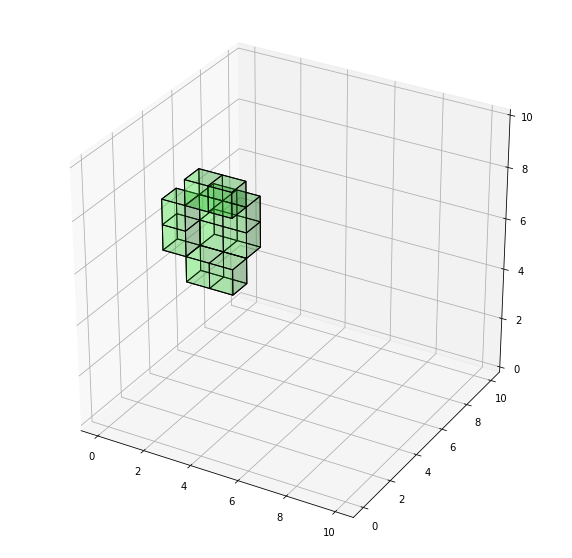

In [967]:
# gm.show_map()

In [26]:
HTML('<img src="' + gm.play() + '"/>')

In [1054]:
collision = np.array([
    np.array(
        [[1, 1, 1, 1],
         [1, 1, 1, 1]])
])

In [1055]:
mp = np.zeros((10, 10, 10))
offset = 4
mp[offset:collision.shape[0] + offset, offset:collision.shape[1] + offset, offset:collision.shape[2] + offset] = collision
# mp

In [1056]:
# Requires (a, b, c, d = 5, 7, 6, 6) rules to collapse
gc = Game3D(map_size=5, positive_ratio=0.7, is_periodic=True, load_map=True, data=mp, map_name='collision')

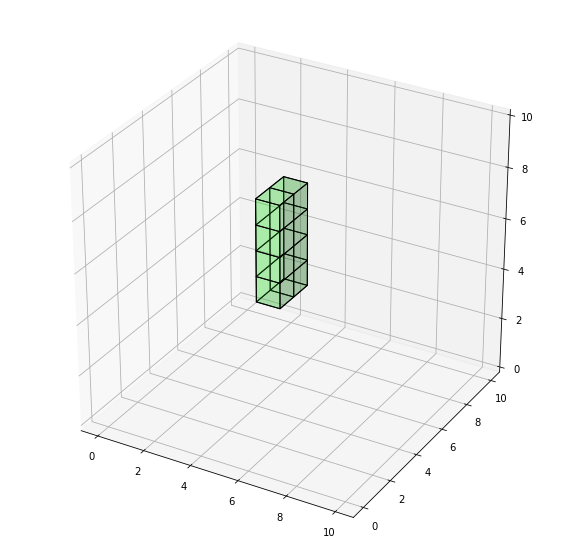

In [929]:
# gc.show_map()

In [1057]:
gc.play()